In [ ]:
import sys
sys.path.append('../')

In [1]:
import numpy as np

import pyssht as ssht
import s2fft as s2f
import s2fft.samples as samples
import s2fft.quadrature as quadrature
import s2fft.resampling as resampling
import s2fft.wigner as wigner
import s2fft.healpix_ffts as hp
import healpy as hpy

import jax
from jax import jit, device_put
import jax.numpy as jnp
from jax.config import config

import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

In [3]:
## Sample data

# input params
L = 5  # 128 # in tests: 5
spin = 2  # 2 # in tests: [0, 1, 2]
sampling = "mw"  #'dh' # in tests: ["mw", "mwss", "dh", "healpix"]
nside = None #[2,4,8] in tests, None if sampling not healpix

# generate spherical harmonics (ground truth)
# random---modify to use JAX random key approach?
DEFAULT_SEED = 8966433580120847635
rn_gen = np.random.default_rng(DEFAULT_SEED)


# compute signal in time domain with ssht (starting point)
# if healpix: we use the inverse from 'direct'? (or 'sov_fft_vectorized'?)
if sampling == 'healpix':
    flm_gt0 = s2f.utils.generate_flm(rn_gen, L, spin, reality=False) # shape L, 2L-1
    f = s2f.transform._inverse(flm_gt0, L, sampling=sampling, method='direct', nside=nside)
    flm_gt = hpy.sphtfunc.map2alm(np.real(f), lmax=L - 1, iter=0) #ground-truth
    flm_gt = s2f.samples.flm_hp_to_2d(flm_gt, L)
    
else:
    flm_gt = s2f.utils.generate_flm(rn_gen, L, spin, reality=False) # shape L, 2L-1
    f = ssht.inverse(
        s2f.samples.flm_2d_to_1d(flm_gt, L),  # 2D indexed coeffs to 1D indexed
        L,
        Method=sampling.upper(),
        Spin=spin,
        Reality=False,
    )

In [4]:
# Using SOV + FFT Vectorised
method_str = "sov_fft_vectorized"
flm_sov_fft_vec = s2f.transform._forward(f, L, spin, sampling, method=method_str, nside=nside)

print(np.allclose(flm_gt, flm_sov_fft_vec, atol=1e-14)) #returns False for healpix

# %timeit s2f.transform._forward(f, L, spin, sampling, method=method_str)

True


In [5]:
# Using SOV + FFT Vectorised JAXed
method_str = "sov_fft_vectorized_jax"
flm_sov_fft_vec_jax = s2f.transform._forward(f, L, spin, sampling, method=method_str, nside=nside) # shape L, 2L-1

print(np.allclose(flm_gt, flm_sov_fft_vec_jax, atol=1e-14))
# print(np.allclose(flm_sov_fft_vec, flm_sov_fft_vec_jax, atol=1e-14)) 
# ---returns True if replacing `wigner.turok.compute_slice(theta, el, L, -spin)` with 
# `np.array(wigner.turok_jax.compute_slice(theta, el, L, -spin))` in _compute_forward_sov_fft_vectorized

# %timeit s2f.transform._forward(f, L, spin, sampling, method=method_str)


True


In [ ]:
# Compare real part
plt.figure()
plt.imshow(flm_sov_fft_vec_jax.real)
plt.title('forward sov fft vec JAX - Re')

plt.figure()
plt.imshow(flm_sov_fft_vec.real)
plt.title('forward sov fft vec - Re')

plt.figure()
plt.imshow(np.isclose(flm_sov_fft_vec_jax.real,
                      flm_sov_fft_vec.real,
                      atol=1e-14))
plt.colorbar()

In [ ]:
# Compare Im part
plt.figure()
plt.imshow(flm_sov_fft_vec_jax.imag)
plt.title('forward sov fft vec JAX - Im')

plt.figure()
plt.imshow(flm_sov_fft_vec.imag)
plt.title('forward sov fft vec - Im')

plt.figure()
plt.imshow(np.isclose(flm_sov_fft_vec_jax.imag,
                      flm_sov_fft_vec.imag,
                      atol=1e-14))
plt.colorbar()

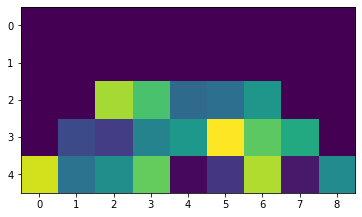

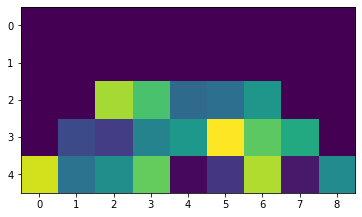

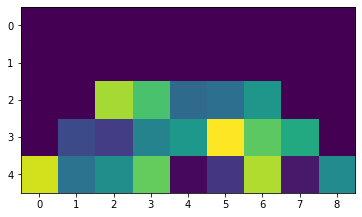

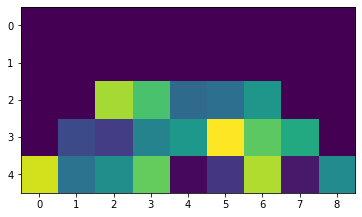

In [9]:
# Mask
import numpy as np

A = np.triu(flm_sov_fft_vec_jax.imag.T,k=-(L-1))
B = np.triu(np.fliplr(flm_sov_fft_vec_jax.imag).T,k=-(L-1))

plt.figure()
plt.imshow(flm_sov_fft_vec.imag)

plt.figure()
plt.imshow(flm_sov_fft_vec_jax.imag)

plt.figure()
plt.imshow(A.T)

plt.figure()
plt.imshow(np.fliplr(B.T))

Text(0.5, 1.0, 'output')

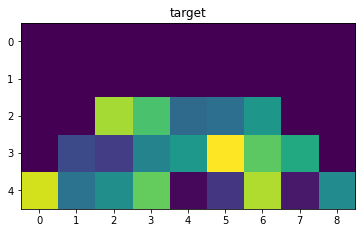

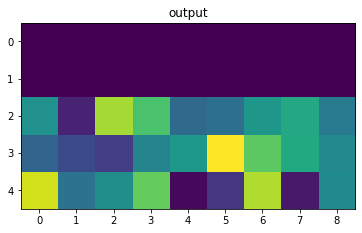

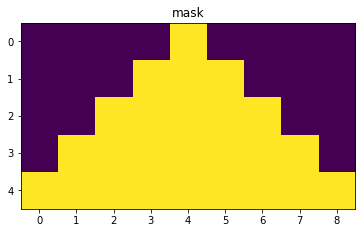

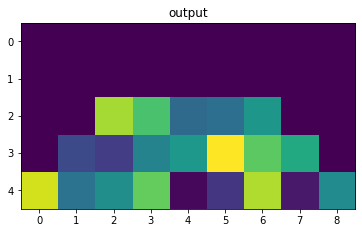

In [41]:
# Design mask for flm jax output?
import numpy as np

A = np.triu(np.ones_like(flm_sov_fft_vec_jax,dtype=bool).T,k=-(L-1))
B = np.fliplr(A.T)
C = A.T*B

plt.figure()
plt.imshow(flm_sov_fft_vec.imag)
plt.title('target')

plt.figure()
plt.imshow(flm_sov_fft_vec_jax.imag)
plt.title('output')

plt.figure()
plt.imshow(C)
plt.title('mask')

plt.figure()
plt.imshow(flm_sov_fft_vec_jax.imag*C)
plt.title('output')